## Perpay Bike Share Data Challenge
By: Mia Tran

**1. Imports and Set up**

In [13]:
# Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [ ]:
# Set up path
sns.set(style="whitegrid", font_scale=1.1)
DATA_DIR = Path("..") / "data"

print("Notebook CWD:", Path.cwd())
print("Data dir exists?:", DATA_DIR.exists(), "->", DATA_DIR.resolve())

# Confirm CSV files
csv_paths = sorted(DATA_DIR.rglob("*.csv"))
print(f"Found {len(csv_paths)} CSVs under {DATA_DIR}")
for p in csv_paths[:10]:
    print(" •", p.name)


Notebook CWD: /Users/tranmaiphuong/Documents/perpay-bike-share-challenge/notebooks
Data dir exists?: True -> /Users/tranmaiphuong/Documents/perpay-bike-share-challenge/data
Found 23 CSVs under ../data
 • indego-trips-2020-q1.csv
 • indego-trips-2020-q2.csv
 • indego-trips-2020-q3.csv
 • indego-trips-2020-q4.csv
 • indego-trips-2021-q1.csv
 • indego-trips-2021-q2.csv
 • indego-trips-2021-q3.csv
 • indego-trips-2021-q4.csv
 • indego-trips-2022-q1.csv
 • indego-trips-2022-q2.csv


**2. Load and Combine Data**

In [30]:
dfs = []
for f in csv_paths:
    df = pd.read_csv(f, low_memory=False)
    df["source_file"] = f.name
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print(f"✅ Loaded {len(data):,} rows from {len(dfs)} files.")


✅ Loaded 5,986,829 rows from 23 files.


**3. Data Cleaning**

In [ ]:
# Convert datetime columns (since pandas may infer them differently across files)
data["start_time"] = pd.to_datetime(data["start_time"], errors="coerce")
data["end_time"]   = pd.to_datetime(data["end_time"], errors="coerce")

# Keep valid trip durations (1–1440 min = 24 hours) for consistency
data = data[(data["duration"] >= 1) & (data["duration"] <= 1440)]

# Extract calendar fields
data["year"] = data["start_time"].dt.year
data["month"] = data["start_time"].dt.month
data["quarter"] = ((data["month"] - 1) // 3 + 1).astype(int) # Computes which quarter the month belongs to
data["year_quarter"] = data["year"].astype(str) + "-Q" + data["quarter"].astype(str) # Combines into a string like "2025-Q3".

# Look at data head
data.head(10)

In [35]:
# Quarterly Summary
summary = (data.groupby("year_quarter").agg(trips=("trip_id", "count"),# total trips that quarter 
                                            total_minutes=("duration", "sum"), # total riding minutes that quarter
                                            avg_duration=("duration", "mean"), # average riding duration that quarter (in minutes)
                                            unique_bikes=("bike_id", "nunique"), # unique bikes that were used that quarter
                                            active_stations=("start_station", "nunique")) # unique stations were used that quarter
                                            ).reset_index()

# Sort chronologically
def sort_key(yq: str):
    y, q = yq.split("-Q")
    return (int(y), int(q))

summary = summary.sort_values("year_quarter", key=lambda s: s.map(sort_key)).reset_index(drop=True)

# Calculate growth metrics

# Quarter-over-Quarter Growth
summary["trips_growth_qoq"] = summary["trips"].pct_change()
summary["total_minutes_growth_qoq"] = summary["total_minutes"].pct_change()
summary["avg_duration_growth_qoq"] = summary["avg_duration"].pct_change()
summary["unique_bikes_growth_qoq"] = summary["unique_bikes"].pct_change()
summary["active_stations_growth_qoq"] = summary["active_stations"].pct_change()

# Year-over-Year Growth
summary["trips_growth_yoy"] = summary["trips"].pct_change(4)
summary["total_minutes_growth_yoy"] = summary["total_minutes"].pct_change(4)
summary["avg_duration_growth_yoy"] = summary["avg_duration"].pct_change(4)
summary["unique_bikes_growth_yoy"] = summary["unique_bikes"].pct_change(4)
summary["active_stations_growth_yoy"] = summary["active_stations"].pct_change(4)
summary.head(10)


,year_quarter,trips,total_minutes,avg_duration,unique_bikes,active_stations,trips_growth_qoq,total_minutes_growth_qoq,avg_duration_growth_qoq,unique_bikes_growth_qoq,active_stations_growth_qoq,trips_growth_yoy,total_minutes_growth_yoy,avg_duration_growth_yoy,unique_bikes_growth_yoy,active_stations_growth_yoy
0,2020-Q1,118190,2404732,20.346324,1427,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-Q2,186586,7320890,39.236009,1520,144,0.578695,2.044368,0.928408,0.065172,0.006993,NaN,NaN,NaN,NaN,NaN
2,2020-Q3,269985,7368593,27.292601,1413,144,0.446974,0.006516,-0.304399,-0.070395,0.000000,NaN,NaN,NaN,NaN,NaN
3,2020-Q4,160401,3472531,21.649061,1303,145,-0.405889,-0.528739,-0.206779,-0.077849,0.006944,NaN,NaN,NaN,NaN,NaN
4,2021-Q1,96281,1949225,20.245168,1318,145,-0.399748,-0.438673,-0.064848,0.011512,0.000000,-0.185371,-0.189421,-0.004972,-0.076384,0.013986
5,2021-Q2,232195,4926025,21.215035,1428,154,1.411639,1.527171,0.047906,0.083460,0.062069,0.244440,-0.327128,-0.459297,-0.060526,0.069444
6,2021-Q3,407697,7628144,18.710327,1559,168,0.755839,0.548539,-0.118063,0.091737,0.090909,0.510073,0.035224,-0.314454,0.103326,0.166667
7,2021-Q4,222955,3642788,16.338669,1451,169,-0.453136,-0.522454,-0.126757,-0.069275,0.005952,0.389985,0.049030,-0.245294,0.113584,0.165517
8,2022-Q1,129073,2120097,16.425565,1406,175,-0.421080,-0.418002,0.005318,-0.031013,0.035503,0.340586,0.087662,-0.188667,0.066768,0.206897
9,2022-Q2,257350,4913604,19.093079,1516,181,0.993833,1.317632,0.162400,0.078236,0.034286,0.108336,-0.002522,-0.100021,0.061625,0.175325


**4. Data Visualization**

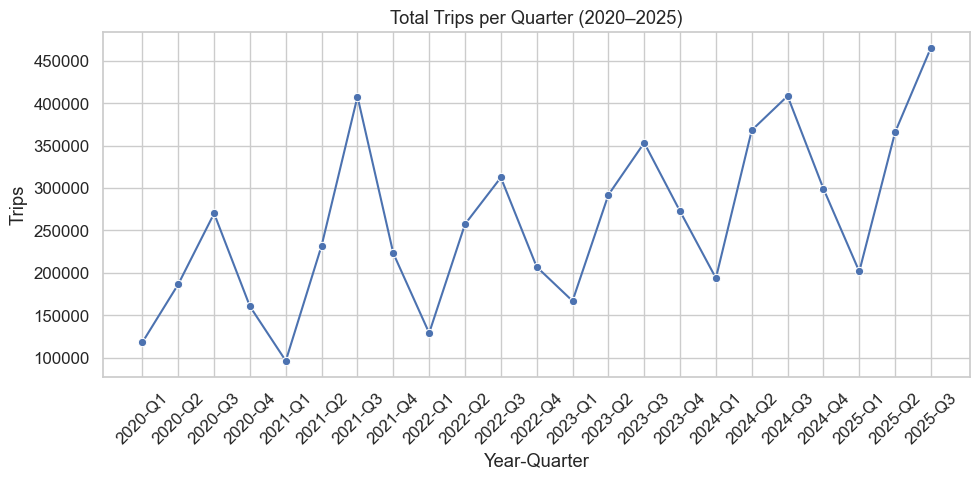

In [38]:
# Total Trips per Quarter
plt.figure(figsize=(10,5))
sns.lineplot(data = summary, x="year_quarter", y="trips", marker="o")
plt.title("Total Trips per Quarter (2020–2025)")
plt.xticks(rotation=45)
plt.ylabel("Trips")
plt.xlabel("Year-Quarter")
plt.tight_layout()
plt.show()


The number of bike trips shows strong seasonality, peaking in spring and summer (Q2–Q3) and dipping in colder quarters (Q1–Q4). After the initial COVID-related slowdown in 2020–2021, Indego experienced steady growth, with trips reaching record highs by 2025. This reflects a healthy expansion and sustained user adoption.

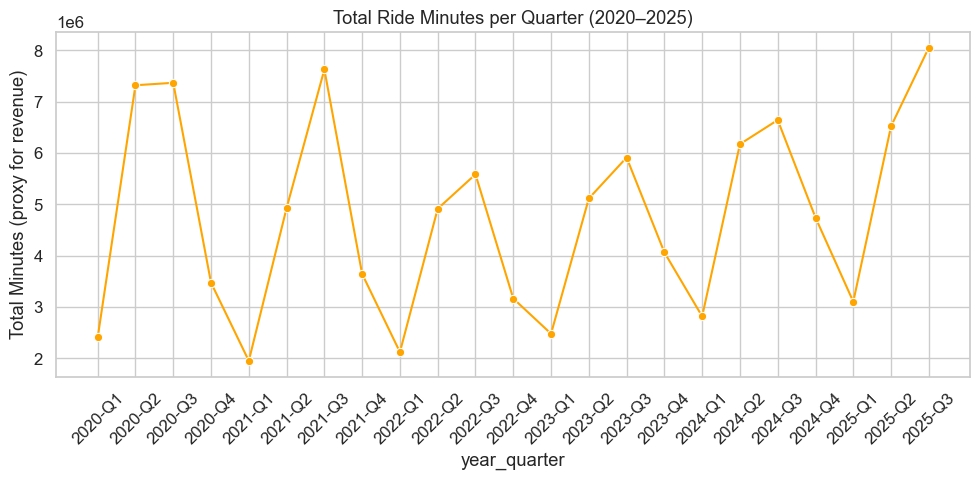

In [ ]:
# Total Ride Minutes per Quarter (Proxy for Revenue)
plt.figure(figsize=(10,5))
sns.lineplot(data=summary, x="year_quarter", y="total_minutes", marker="o", color="orange")
plt.title("Total Ride Minutes per Quarter (2020–2025)")
plt.xticks(rotation=45)
plt.ylabel("Total Minutes (proxy for revenue)")
plt.tight_layout()
plt.show()


Total ride minutes — a proxy for revenue — follow a similar seasonal pattern to total trips, with clear peaks during warmer months. Overall usage has more than tripled since 2020, indicating strong engagement and revenue growth. The rising baseline suggests that demand is expanding sustainably, driven by recurring and new riders alike.

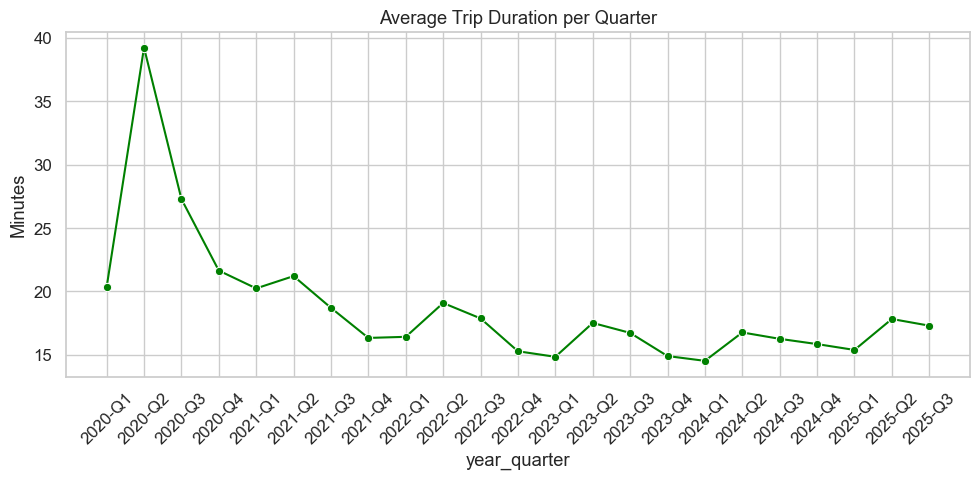

In [37]:
# Average Trip Duration per Quarter
plt.figure(figsize=(10,5))
sns.lineplot(data = summary, x = "year_quarter", y = "avg_duration", marker="o", color="green")
plt.title("Average Trip Duration per Quarter")
plt.xticks(rotation=45)
plt.ylabel("Minutes")
plt.tight_layout()
plt.show()

Average trip duration peaked in early 2020, likely due to pandemic-era leisure rides, and stabilized around 15–20 minutes afterward. This indicates a shift toward shorter, routine trips (commuting or errands), suggesting Indego has matured from a novelty to a reliable daily transport service.

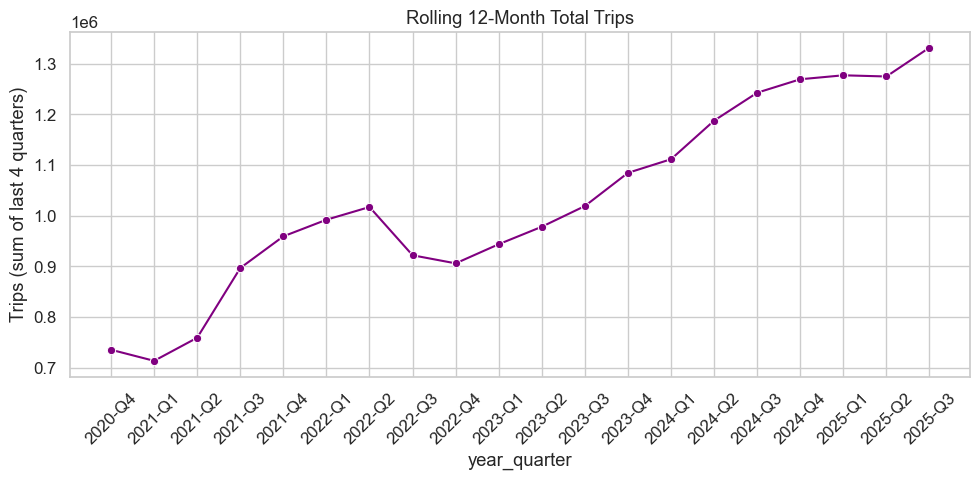

In [28]:
# Rolling 12-Month Total Trips

# Compute rolling 12-month (4 quarters) total trips
summary["rolling_year_trips"] = summary["trips"].rolling(window=4).sum()

plt.figure(figsize=(10,5))
sns.lineplot(data=summary, x="year_quarter", y="rolling_year_trips", marker="o", color="purple")
plt.title("Rolling 12-Month Total Trips")
plt.xticks(rotation=45)
plt.ylabel("Trips (sum of last 4 quarters)")
plt.tight_layout()
plt.show()


The rolling 12-month trend smooths out seasonal variation and shows continuous growth since 2021. Annual trips nearly doubled by 2025, indicating consistent adoption without signs of overgrowth or decline. The slight plateau after 2024 suggests that Indego is transitioning into a stable, sustainable growth phase.

In [29]:
# Growth Summary

avg_qoq_growth = summary["trips_growth_qoq"].mean(skipna=True)
avg_yoy_growth = summary["trips_growth_yoy"].mean(skipna=True)

print(f"Average Quarter-over-Quarter Trips Growth: {avg_qoq_growth:.2%}")
print(f"Average Year-over-Year Trips Growth: {avg_yoy_growth:.2%}")

Average Quarter-over-Quarter Trips Growth: 18.79%
Average Year-over-Year Trips Growth: 14.88%


On average, Indego’s trips grew by roughly 14.88% year-over-year, reflecting a sustainable pace of expansion. This balance between growth and stability positions the program for long-term operational efficiency.

**5. Summary & Insights**

**a. Quantifying Growth**

To quantify Indego’s program growth, quarterly aggregation provides a clear and repeatable metric set:
- **Total Trips** — measures total utilization and program demand.  
- **Total Ride Minutes** — a proxy for total revenue or engagement time.  
- **Unique Bikes and Active Stations** — represent infrastructure expansion.  
- **Quarter-over-Quarter (QoQ) and Year-over-Year (YoY) Growth Rates** — capture short-term acceleration and long-term sustainability.

Using these metrics, the program achieved an **average YoY trips growth of ~14.9%**, with consistent seasonal peaks in Q2–Q3 and declines in colder quarters.


**b. Evaluating Growth Pace**

There is **no evidence that Indego is growing too slowly or unsustainably fast.**
- Growth after 2021 has been **steady and organic**, following recovery from early-pandemic declines.  
- The **rolling 12-month total trips** show continuous upward momentum, nearly **doubling by 2025** without major volatility.
- Seasonal fluctuations are stable and predictable — suggesting that demand is not driven by short-lived spikes.

This pattern reflects a **healthy, maturing system**: demand is increasing, but not outpacing infrastructure or supply.


**c. Recommendations for Strategic Growth**

Executives should aim for **sustained, data-driven expansion** rather than aggressive scaling. Key recommendations:
- **Focus on retention and consistency** — Encourage year-round ridership through loyalty programs or winter discounts.
- **Expand station density in high-growth corridors**, especially areas showing persistent trip demand during off-peak seasons.
- **Invest in predictive analytics** to forecast bike availability and rebalancing needs, improving operational efficiency.
- **Track QoQ and YoY growth dashboards** as KPIs for performance management.

**Bottom Line:**  
Indego’s growth trajectory (≈15% YoY) reflects strong user adoption, healthy utilization, and operational stability. The program should maintain its current growth pace while optimizing resource allocation and customer retention strategies.
